In [3]:
import numpy as np
import pandas as pd
deliveries=pd.read_csv("./deliveries.csv")
matches=pd.read_csv("./matches.csv")

In [4]:
teams=['Mumbai Indians', 'Kolkata Knight Riders','Rajasthan Royals', 'Chennai Super Kings','Sunrisers Hyderabad','Delhi Capitals', 'Punjab Kings','Lucknow Super Giants', 'Gujarat Titans','Royal Challengers Bengaluru']

In [5]:
matches['team1']=matches['team1'].str.replace('Royal Challengers Bangalore','Royal Challengers Bengaluru')
matches['team1']=matches['team1'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
matches['team1']=matches['team1'].str.replace('Kings XI Punjab','Punjab Kings')
matches['team1']=matches['team1'].str.replace('Delhi Daredevils','Delhi Capitals')
matches['team2']=matches['team2'].str.replace('Royal Challengers Bangalore','Royal Challengers Bengaluru')
matches['team2']=matches['team2'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
matches['team2']=matches['team2'].str.replace('Kings XI Punjab','Punjab Kings')
matches['team2']=matches['team2'].str.replace('Delhi Daredevils','Delhi Capitals')
matches['winner']=matches['winner'].str.replace('Royal Challengers Bangalore','Royal Challengers Bengaluru')
matches['winner']=matches['winner'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
matches['winner']=matches['winner'].str.replace('Kings XI Punjab','Punjab Kings')
matches['winner']=matches['winner'].str.replace('Delhi Daredevils','Delhi Capitals')
matches=matches[matches['team1'].isin(teams)]
matches=matches[matches['team2'].isin(teams)]
matches=matches[matches['method']!='D/L']
matches= matches[['id','city','winner','target_runs','target_overs']]
delivery_df=matches.merge(deliveries,left_on='id',right_on='match_id')
delivery_df=delivery_df[delivery_df["inning"]==2]

In [6]:
delivery_df['total_runs_scored']=delivery_df.groupby('match_id')['total_runs'].cumsum()
delivery_df['runs_left']=delivery_df['target_runs']-delivery_df['total_runs_scored']
delivery_df['balls_left']=delivery_df['target_overs']*6-delivery_df['over']*6-delivery_df['ball']
# delivery_df = delivery_df.drop(['id'], axis=1)

In [7]:
delivery_df['RRR']=(delivery_df['runs_left']*6)/delivery_df['balls_left']
delivery_df['CRR']=(delivery_df['total_runs_scored']*6)/(delivery_df['target_overs']*6-delivery_df['balls_left'])
delivery_df['fow']=delivery_df.groupby('match_id')['is_wicket'].cumsum()
delivery_df['wickets_left']=10-delivery_df['fow']
delivery_df=delivery_df.drop(['fow'],axis=1)

In [8]:
def func(row):
    return 1 if row['batting_team']==row['winner'] else 0
delivery_df['result']=delivery_df.apply(func,axis=1)

In [9]:
final_df=delivery_df[['batting_team','bowling_team','city','target_runs','runs_left','balls_left','wickets_left','CRR','RRR','result']]
final_df=final_df.sample(final_df.shape[0])

In [29]:
final_df.dropna(inplace=True)
final_df=final_df[final_df['balls_left']>0]


In [30]:
final_df.shape

(105219, 10)

In [31]:
from sklearn.model_selection import train_test_split
X=final_df.iloc[:,:-1]
y=final_df.iloc[:,-1]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1) 

In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

trf = ColumnTransformer([
    ('trf',OneHotEncoder(drop='first'),['batting_team','bowling_team','city'])
]
,remainder='passthrough')

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

In [38]:
pipe = Pipeline(steps=[
    ('step1',trf),
    ('step2',LogisticRegression(solver='liblinear'))
])

In [39]:
pipe.fit(X_train,y_train)

c:\Users\ABISHEK\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first'),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2', LogisticRegression(solver='liblinear'))])

In [40]:
y_pred=pipe.predict(X_test)

In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.8741684090477095

In [59]:
def match_progression(x_df,match_id,pipe):
    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]
    temp_df = match[['batting_team','bowling_team','city','runs_left','balls_left','wickets_left','target_runs','CRR','RRR']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]
    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0]*100,1)
    temp_df['win'] = np.round(result.T[1]*100,1)
    temp_df['end_of_over'] = range(1,temp_df.shape[0]+1)
    target = temp_df['target_runs'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0,target)
    temp_df['runs_after_over'] = (np.array(runs)[:-1] - np.array(new_runs))
    wickets = list(temp_df['wickets_left'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0,10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]
    
    print("Target-",target)
    temp_df = temp_df[['end_of_over','runs_after_over','wickets_in_over','lose','win']]
    return temp_df,target
    

In [60]:
temp_df,target = match_progression(delivery_df,1426269,pipe)
temp_df

Target- 224.0


,end_of_over,runs_after_over,wickets_in_over,lose,win
221364,1,7.0,0,83.2,16.8
221371,2,16.0,1,81.1,18.9
221377,3,11.0,0,76.3,23.7
221385,4,12.0,0,69.4,30.6
221391,5,6.0,1,77.9,22.1
221398,6,20.0,0,60.1,39.9
221405,7,13.0,0,49.7,50.3
221412,8,13.0,1,49.5,50.5
221418,9,3.0,1,65.6,34.4
221425,10,8.0,0,63.8,36.2


Text(0.5, 1.0, 'Target-224.0')

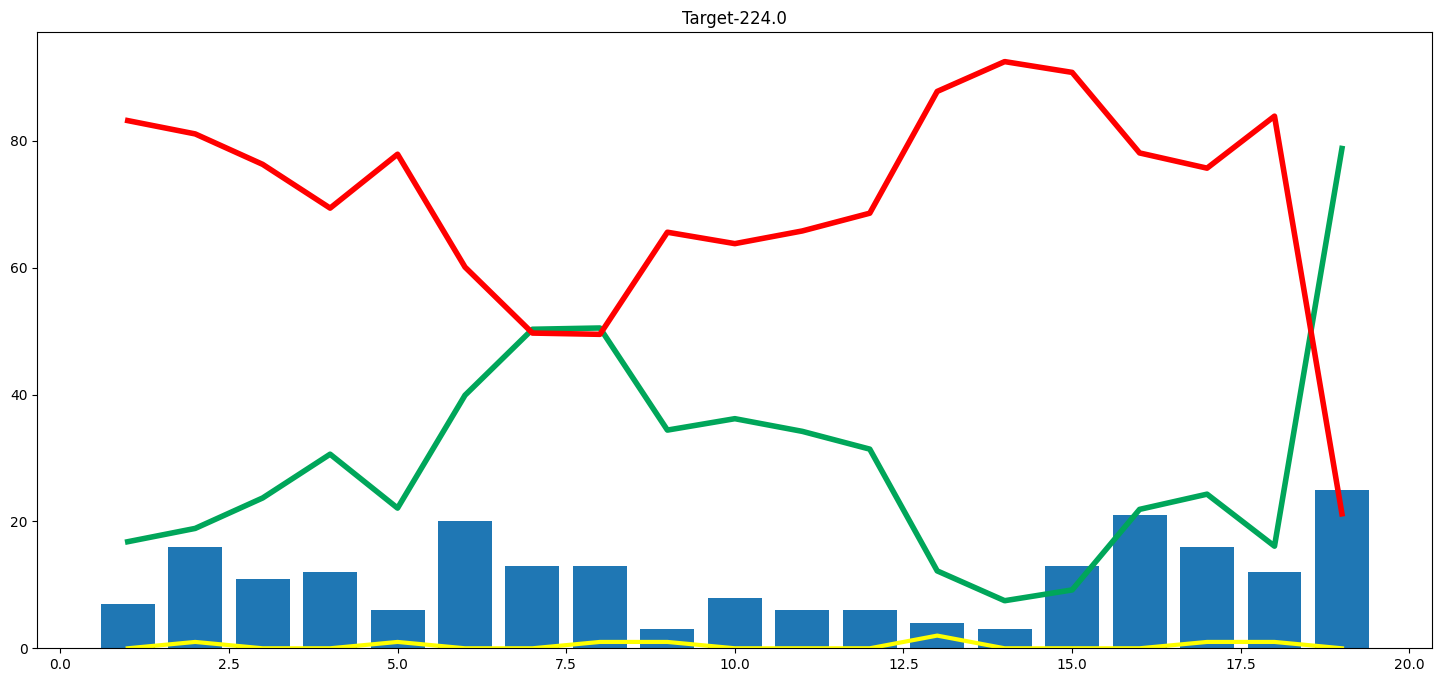

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,8))
plt.plot(temp_df['end_of_over'],temp_df['wickets_in_over'],color='yellow',linewidth=3)
plt.plot(temp_df['end_of_over'],temp_df['win'],color='#00a65a',linewidth=4)
plt.plot(temp_df['end_of_over'],temp_df['lose'],color='red',linewidth=4)
plt.bar(temp_df['end_of_over'],temp_df['runs_after_over'])
plt.title('Target-' + str(target))

In [62]:
delivery_df['city'].unique()

array(['Bangalore', 'Chandigarh', 'Delhi', 'Mumbai', 'Kolkata', 'Jaipur',
       'Hyderabad', 'Chennai', 'Cape Town', 'Port Elizabeth', 'Durban',
       'Centurion', 'East London', 'Johannesburg', 'Kimberley',
       'Bloemfontein', 'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala',
       'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi', 'Abu Dhabi', nan,
       'Bengaluru', 'Indore', 'Dubai', 'Sharjah', 'Navi Mumbai',
       'Lucknow', 'Guwahati', 'Mohali'], dtype=object)

In [63]:
teams

['Mumbai Indians',
 'Kolkata Knight Riders',
 'Rajasthan Royals',
 'Chennai Super Kings',
 'Sunrisers Hyderabad',
 'Delhi Capitals',
 'Punjab Kings',
 'Lucknow Super Giants',
 'Gujarat Titans',
 'Royal Challengers Bengaluru']

In [64]:
import pickle
pickle.dump(pipe,open('pipe.pkl','wb'))